# Toxic Comment Classification

From Kaggle challenge: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

The objective is to detect the type(s) of toxicity (e.g. threats, obscenity, insults, and identity-based hate) of a comment. One comment can be tagged with multiple types or with none, i.e. non-toxic.

In this notebook, we'll build a LSTM network with PyTorch

## Libraries

In [1]:
!pip install torchsummaryX

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from collections import Counter
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
from typing import Optional
%matplotlib inline

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummaryX import summary

## Custom Functions

In [3]:
def train_classifier(model:"nn.Module", epochs:int, train_loader:"DataLoader", val_loader:"DataLoader",
                     criterion:"loss function", optimizer:"optim.Optimizer", device:"torch.device",
                     scheduler:"LR scheduler" = None, threshold:float = 0.5) -> "List[float]":
    """
    """
    lrs = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs} - ', end='')

        loss_epoch, val_loss_epoch = 0, 0
        acc_epoch, val_acc_epoch = 0, 0
        t0 = time.time()

        for phase in ['train', 'val']:
            running_loss = 0
            running_samples = 0
            running_corrects = 0
            running_tot = 0

            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
                optimizer.zero_grad()
            else:
                model.eval()   # Set model to evaluate mode
                loader = val_loader

            for batch in loader:
                X, y = batch
                X, y = X.to(device), y.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outs = model(X)
                    dims = len(y.shape)
                    if dims == 1: # Single label
                        y_pred = outs.argmax(1)
                    else:
                        y_pred = outs > threshold
                    loss = criterion(outs, y)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()
                        optimizer.zero_grad()
                        lrs.append(optimizer.param_groups[0]['lr']) # TODO: generalize

                running_loss += loss.item() * X.shape[0] # Loss reduction='mean'
                running_samples += y.shape[0]
                running_corrects += torch.sum(y_pred == y).item()
                running_tot += y.nelement()
            
            if phase == 'train':
                loss_epoch = running_loss / running_samples
                acc_epoch = running_corrects / running_tot
            else:
                val_loss_epoch = running_loss / running_samples
                val_acc_epoch = running_corrects / running_tot

        duration = time.time() - t0
        print(f'{duration:.2f}s {duration * 1e3 / (len(train_loader) + len(val_loader)):.2f}ms/step - ', end='')
        print(f'loss: {loss_epoch}, acc: {acc_epoch} - val_loss: {val_loss_epoch}, val_acc: {val_acc_epoch}')

    return lrs

def predict_classes(single:bool, model:"nn.Module", loader:"DataLoader", device:"torch.device",
                    threshold:float = 0.5) -> "Tuple[np.ndarray, np.ndarray]":
    """
    """
    probas = []
    preds = []
    t0 = time.time()
    model.eval()   # Set model to evaluate mode

    for batch in loader:
        X = batch.to(device)

        with torch.no_grad():
            outs = model(X)
            if single: # Single label
                y_pred = outs.argmax(1).cpu().numpy()
            else:
                y_pred = (outs > threshold).cpu().numpy()

        probas.append(outs.cpu().numpy())
        preds.append(y_pred)

    duration = time.time() - t0
    print(f'Prediction - {duration:.2f}s')

    probas = np.concatenate(probas, axis=0)
    preds = np.concatenate(preds, axis=0)

    return probas, preds

## Data Analysis & Processing

### Loading & Inspection

In [4]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [5]:
print(f'Size of dataset - train: {train.shape}, test: {test.shape}')

Size of dataset - train: (159571, 8), test: (153164, 2)


In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

There are no missing values

Let's add a new column for *normal* comments (i.e. non-toxic) and investigate the distribution of the data

In [9]:
# Add column 'normal' for non-toxic comments
train['normal'] = (train.loc[:, 'toxic':'identity_hate'].sum(axis=1) < 1).astype(int)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normal
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


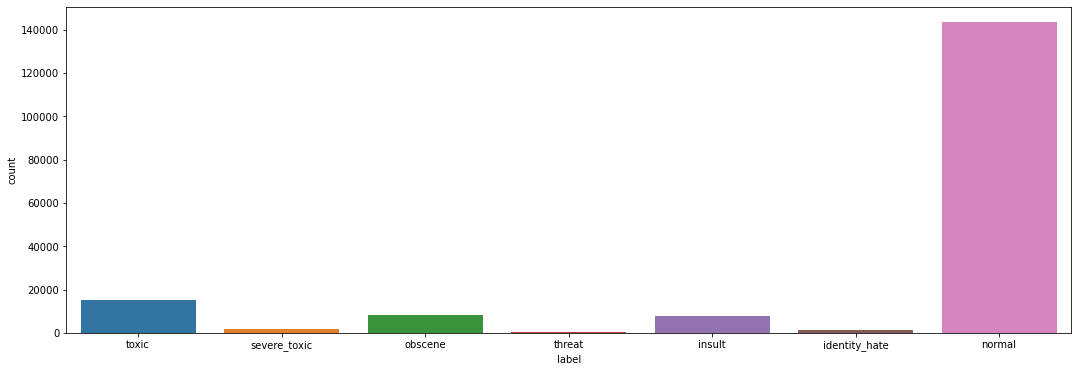

In [10]:
tmp = train.loc[:, 'toxic':'normal'].sum().reset_index()
tmp.columns = ['label', 'count']
plt.figure(figsize=(18, 6))
ax = sns.barplot(x='label', y='count', data=tmp)

There is a majority of non-toxic comments while there are some toxic labels that appear more frequently than others

### Tokenization

In [11]:
train_texts = train["comment_text"]
test_texts = test["comment_text"]

train_tokens_raw = [text_to_word_sequence(text) for text in train_texts]
test_tokens_raw = [text_to_word_sequence(text) for text in test_texts]

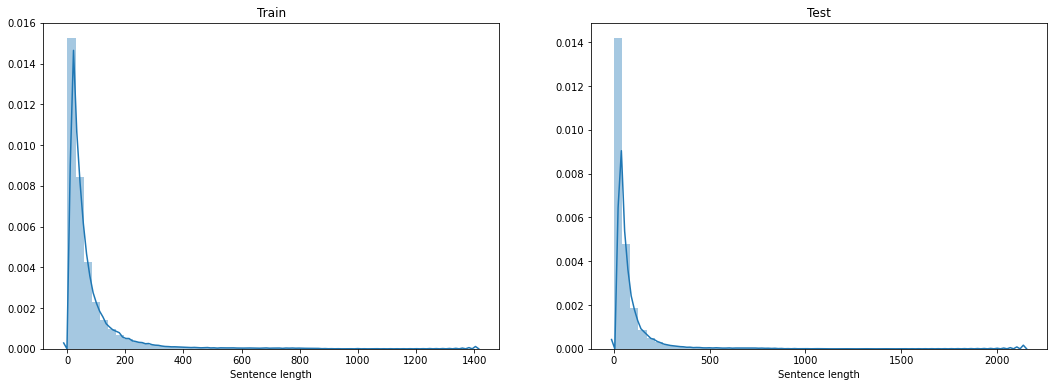

In [12]:
train_sentence_len = [len(sentence) for sentence in train_tokens_raw]
test_sentence_len = [len(sentence) for sentence in test_tokens_raw]

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.distplot(train_sentence_len, ax=ax[0])
ax[0].set_xlabel('Sentence length')
ax[0].set_title('Train')
sns.distplot(test_sentence_len, ax=ax[1])
ax[1].set_xlabel('Sentence length')
_ = ax[1].set_title('Test')

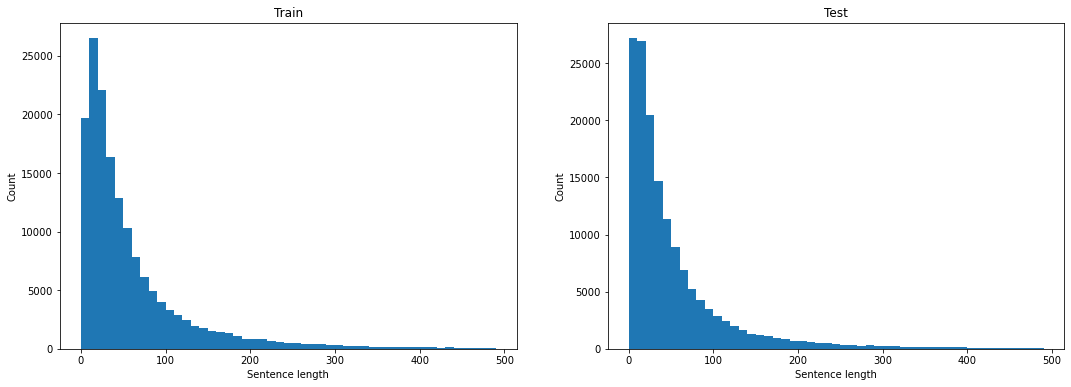

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].hist(train_sentence_len, bins=np.arange(0, 500, 10))
ax[0].set_xlabel('Sentence length')
ax[0].set_ylabel('Count')
ax[0].set_title('Train')
ax[1].hist(test_sentence_len, bins=np.arange(0, 500, 10))
ax[1].set_xlabel('Sentence length')
ax[1].set_ylabel('Count')
_ = ax[1].set_title('Test')

Most of the sentences don't have that many tokens. We'll use a fixed length sequence model later on and 200 seems to be a good value for the maximum sequence length

In [14]:
def get_counter(seq_list):
    counter = Counter()
    for seq in seq_list:
        counter.update(seq)
    return counter

train_counter = get_counter(train_tokens_raw)
test_counter = get_counter(test_tokens_raw)

print(f'Number of unique words in dataset - train: {len(train_counter.keys())}, test: {len(test_counter.keys())}')

Number of unique words in dataset - train: 210337, test: 273192


There are more unique words in the test set than the training one

Now let's look at the the frequency of the words in the training set before deciding how many to keep in our vocabulary for training the model (we can go further by looking at the test set too)

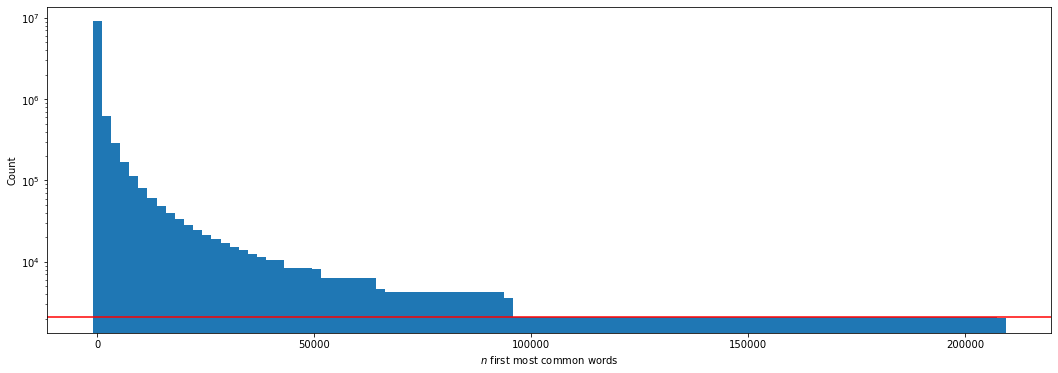

In [15]:
bins = 100
most_common_cnts = sorted(train_counter.values(), reverse=True)
step = int(np.ceil(len(most_common_cnts) / bins))
binned = [np.sum(most_common_cnts[i*step:(i+1)*step]) for i in range(bins)]
idx = np.arange(0, step*bins, step)

fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.bar(idx, binned, width=step)
ax.set_xlabel('$n$ first most common words')
ax.set_ylabel('Count')
ax.set_yscale('log')
_ = ax.hlines(step, 0, 1, transform=ax.get_yaxis_transform(), colors='r') # All words appear only once

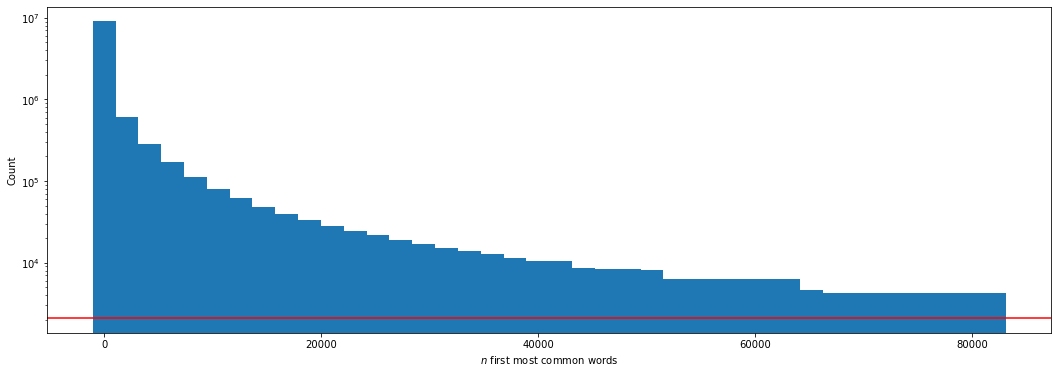

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.bar(idx[:40], binned[:40], width=step)
ax.set_xlabel('$n$ first most common words')
ax.set_ylabel('Count')
ax.set_yscale('log')
_ = ax.hlines(step, 0, 1, transform=ax.get_yaxis_transform(), colors='r') # All words appear only once

Many words only appear once and might thus not be very relevant so we can exclude them from the final vocabulary. For now, let's keep only the first 20 000 most common words

### Numericalization

In [17]:
seq_len = 200
max_vocab = 20000

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(train_texts)

train_tokens_id = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=seq_len)
test_tokens_id = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=seq_len)

## Dataset Preparation

In [18]:
class ToxicDataset(Dataset):
    def __init__(self, tokens_id:np.ndarray, labels:Optional[np.ndarray] = None):
        super(ToxicDataset, self).__init__()
        self.tokens_id = torch.as_tensor(tokens_id, dtype=torch.int64)
        self.labels = torch.as_tensor(labels, dtype=torch.float32) if labels is not None else labels

    def __len__(self):
        return self.tokens_id.shape[0]

    def __getitem__(self, idx:int):
        X = self.tokens_id[idx, :]
        if self.labels is not None:
            y = self.labels[idx, :]
            return X, y
        else:
            return X

y = train.loc[:, 'toxic':'identity_hate'].to_numpy()
X, X_val, y, y_val = train_test_split(train_tokens_id, y, test_size=0.1)

train_data = ToxicDataset(X, y)
val_data = ToxicDataset(X_val, y_val)
test_data = ToxicDataset(test_tokens_id)

batch_size = 32
nb_workers = 4

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=nb_workers, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=nb_workers, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1024, num_workers=2, pin_memory=True)

## Model (LSTM)

In [19]:
# Define device variable for switching between CPU/GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [20]:
class ToxicModel(nn.Module):
    def __init__(self, nb_embeds, embed_dim, hidden):
        super(ToxicModel, self).__init__()
        self.embed = nn.Embedding(nb_embeds, embed_dim)
        self.drop2d = nn.Dropout2d(0.2)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.conv = nn.Conv1d(hidden*2, 64, 3, padding=1, padding_mode='reflect')
        self.max = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 6),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embed(x)
        x = self.drop2d(x)
        x, (h_n, c_n) = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.max(x)
        x = self.fc(x)
        return x

model = ToxicModel(max_vocab, 128, 128)
model.to(device)
summary(model, torch.zeros((2, seq_len), dtype=torch.int64, device=device))

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), eps=1e-7)

                Kernel Shape   Output Shape    Params Mult-Adds
Layer                                                          
0_embed         [128, 20000]  [2, 200, 128]     2.56M     2.56M
1_drop2d                   -  [2, 200, 128]         -         -
2_lstm                     -  [2, 200, 256]  264.192k  262.144k
3_conv          [256, 64, 3]   [2, 64, 200]   49.216k   9.8304M
4_max                      -     [2, 64, 1]         -         -
5_fc.Flatten_0             -        [2, 64]         -         -
6_fc.Linear_1        [64, 6]         [2, 6]     390.0     384.0
7_fc.Sigmoid_2             -         [2, 6]         -         -
-----------------------------------------------------------------
                          Totals
Total params           2.873798M
Trainable params       2.873798M
Non-trainable params         0.0
Mult-Adds             12.652928M


## LR Finding & Training

In [21]:
gc.collect() # Free some useless memory

epochs = 4
lr = 1e-1
label_thresh = 0.5

lrs = train_classifier(model, epochs, train_loader, val_loader, criterion, optimizer, device, threshold=label_thresh)

Epoch 1/4 - 101.28s 20.31ms/step - loss: 0.06839464219952276, acc: 0.9776471025139322 - val_loss: 0.0493945344294622, val_acc: 0.9824852738438401
Epoch 2/4 - 101.33s 20.32ms/step - loss: 0.052005419824697675, acc: 0.9815928920083836 - val_loss: 0.04629490326383625, val_acc: 0.9829134812215399
Epoch 3/4 - 101.46s 20.34ms/step - loss: 0.047656678846478756, acc: 0.9826733420140702 - val_loss: 0.04845109140885141, val_acc: 0.9822555040314158
Epoch 4/4 - 101.97s 20.45ms/step - loss: 0.044842346488281275, acc: 0.9836342578086014 - val_loss: 0.044777455361615315, val_acc: 0.9830596983749008


## Prediction & Submission

In [22]:
probas, classes = predict_classes(False, model, test_loader, device, threshold=label_thresh)

label_names = ['toxic', 'severe_toxic', 'obscene','threat', 'insult', 'identity_hate']

submission = test['id'].to_frame()
submission = pd.concat([submission, pd.DataFrame(probas, columns=label_names)], axis=1)

submission.to_csv('submission.csv', index=False)

Prediction - 6.05s


In [23]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997070,0.252593,0.990917,1.924106e-01,0.967297,0.441257
1,0000247867823ef7,0.000077,0.000004,0.000055,8.341443e-07,0.000017,0.000003
2,00013b17ad220c46,0.000369,0.000082,0.000272,7.963507e-06,0.000069,0.000021
3,00017563c3f7919a,0.000331,0.000007,0.000368,6.754645e-06,0.000122,0.000013
4,00017695ad8997eb,0.005563,0.000296,0.001170,1.017584e-04,0.000645,0.000246


In [24]:
submission.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,1.531640e+05,153164.000000,1.531640e+05,1.531640e+05,1.531640e+05
mean,0.204432,1.771410e-02,0.135023,5.339144e-03,1.003405e-01,2.606249e-02
std,0.348314,7.391488e-02,0.285265,4.854147e-02,2.325368e-01,1.030840e-01
min,0.000004,3.898439e-08,0.000004,1.051188e-08,6.240433e-07,1.878320e-07
25%,0.000457,3.879100e-06,0.000211,1.428134e-06,6.882507e-05,1.667124e-05
50%,0.003553,3.880190e-05,0.001151,1.427854e-05,5.226284e-04,1.218808e-04
75%,0.232857,1.411677e-03,0.048777,3.634500e-04,2.935079e-02,3.797473e-03
max,0.999941,9.882419e-01,0.999861,9.999865e-01,9.982564e-01,9.995840e-01


In [25]:
test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


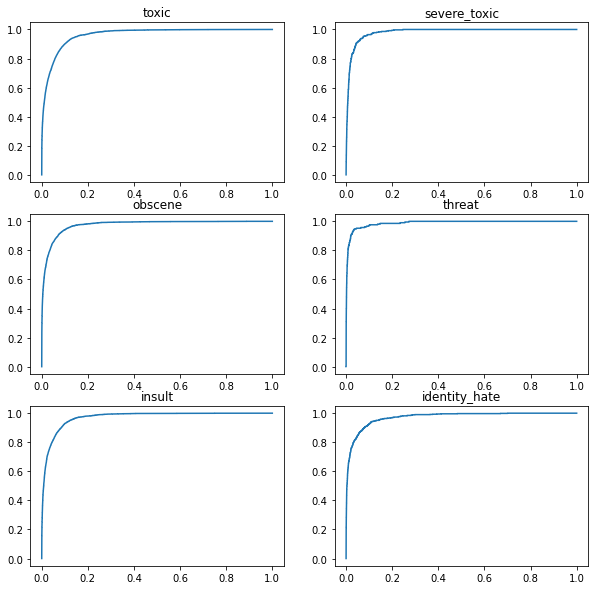

In [26]:
mask = test_labels['toxic'] > -1 # -1 to indicate that this sample is not considered in scoring

rocs = []
for i in range(1, test_labels.shape[1]):
    rocs.append(roc_curve(test_labels[mask].iloc[:, i], submission[mask].iloc[:, i]))

nb_rows = int(np.round((test_labels.shape[1] - 1) / 2))
fig, ax = plt.subplots(nb_rows, 2, figsize=(10, 10))
for i, roc in enumerate(rocs):
    ax_i = ax[i//2][i%2]
    ax_i.plot(roc[0], roc[1])
    ax_i.set_title(test_labels.columns[i+1])

In [27]:
roc_auc = roc_auc_score(test_labels[mask].iloc[:, 1:], submission[mask].iloc[:, 1:])
print(f'ROC AUC score on the test dataset: {roc_auc}')

ROC AUC score on the test dataset: 0.9753639626595421
